### ISC CamCan Suspense

The goal of this notebook is to look into activations as opposed to ISC (which is a topi that would deserve more than this short notebook, but is presented here for completeness).

### setting up modules

In [1]:
import os, sys, scipy, nilearn, warnings
warnings.filterwarnings("ignore")

import numpy as np
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

#import tables as tb         # PyTables library does on disk (i.e. bigger than memory matrices storage)
import matplotlib.pyplot as plt
%matplotlib inline

from camcan_utils import *

### set up files

In [3]:
suspense_file         =  '../../data/avg_suspense.npy'
dict_file             =  '../../data/timeseries_dictionary.npy'
dyn_isc_file          =  '../../data/dyn_isc_dict.npy'
shen_dictionary_file  =  '../../data/shen_dictionary.npy'
shen_atlas_filename   =  '../../data/shen_2mm_268_parcellation.nii'
sample_file           =  '../../data/func.nii'

### load data 

In [4]:
# load the dynamic isc results (precomputed and stored in notebook03 to save time)
dyn_isc_dict = np.load(dyn_isc_file).item() 
dyn_isc_result_all = dyn_isc_dict['dyn_isc_result_all']
dyn_isc_result = dyn_isc_dict['dyn_isc_result_splithalf']
del dyn_isc_dict
shen_dictionary = np.load(shen_dictionary_file).item()

In [5]:
# read in the time series data to get access to the raw BOLD activation values 
read_dictionary = np.load(dict_file).item()

subjs = list(read_dictionary.keys())
n_subjs = len(subjs)
n_tr, n_regions = read_dictionary[subjs[0]]['funcdata'].shape
n_tr_rest, n_regions = read_dictionary[subjs[0]]['funcdata_rest'].shape

ts_data = np.zeros((n_tr, n_regions, n_subjs))
ts_data_undet = np.zeros((n_tr, n_regions,n_subjs))
motion_data = np.zeros((n_tr, 6, n_subjs))
age_data = np.zeros((n_subjs))
gender_data = np.zeros((n_subjs))

rest_list = [] 
#re-create ts_data
for curr_sub in range(n_subjs):
    curr_sub_name                = subjs[curr_sub]
    ts_data[:,:, curr_sub]       = read_dictionary[curr_sub_name]['funcdata']
    ts_data_undet[:,:, curr_sub] = read_dictionary[curr_sub_name]['funcdata_unfilt_undet_stand']
    motion_data[:,:, curr_sub]   = read_dictionary[curr_sub_name]['motion']
    age_data[curr_sub] = read_dictionary[curr_sub_name]['age']
    gender_data[curr_sub] = read_dictionary[curr_sub_name]['gender']
    if np.asarray(read_dictionary[curr_sub_name]['funcdata_rest']).shape == (n_tr_rest, n_regions):
        rest_list.append(read_dictionary[curr_sub_name]['funcdata_rest'])
        #things are a bit cumbersome for the resting state data because - due to artifact control etc, different subjects pass the threshold
        
ts_data_rest = np.asarray(rest_list)
ts_data_rest = np.swapaxes(ts_data_rest, 0,2)
ts_data_rest = np.swapaxes(ts_data_rest, 0,1)
del rest_list, read_dictionary

### compare ISC and raw (activation) results

In [35]:
# compute mean for a region
curr_region = 6 #this is the LFC-region
vals_all    = np.nanmean(ts_data_undet[:, curr_region, :], axis=1)
vals1       = np.nanmean(ts_data_undet[:, curr_region, :247], axis=1)
vals2       = np.nanmean(ts_data_undet[:, curr_region, 247:], axis=1) #248 -> to take average from half of the group

# compute a rolling average as well
roll_vals_all = pd.DataFrame(vals_all).rolling(window = 5, center = True, win_type = 'boxcar', min_periods = 0).mean()[0].values
roll_vals1 = pd.DataFrame(vals1).rolling(window = 5, center = True, win_type = 'boxcar', min_periods = 0).mean()[0].values
roll_vals2 = pd.DataFrame(vals2).rolling(window = 5, center = True, win_type = 'boxcar', min_periods = 0).mean()[0].values

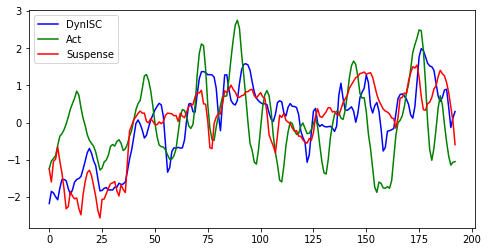

,dyn_isc,roll_act,suspense
dyn_isc,1.000000,0.386516,0.791110
roll_act,0.386516,1.000000,0.340855
suspense,0.791110,0.340855,1.000000


In [36]:
f = plt.figure(figsize=(8,4))
ax1 = f.add_subplot(111)
ax1.plot(scipy.stats.zscore(dyn_isc_result_all[:,curr_region]), 
         color = 'blue', label = 'DynISC');
ax1.plot(scipy.stats.zscore(roll_vals_all), 
         color = 'green', label = 'Act');
ax1.plot(scipy.stats.zscore(suspense), 
         color = 'red', label = 'Suspense');
plt.legend(loc =2)
plt.show()

df_table = {'dyn_isc' : scipy.stats.zscore(dyn_isc_result_all[:,curr_region]),
            'roll_act': scipy.stats.zscore(roll_vals_all),
            'suspense': scipy.stats.zscore(suspense)}
df = pd.DataFrame(df_table)

#df.plot(figsize=(8,4))
df.corr()

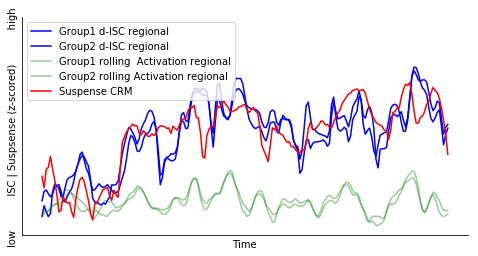

In [37]:
f = plt.figure(figsize=(8,4))
ax1 = f.add_subplot(111)


ax1.plot(scipy.stats.zscore(dyn_isc_result[0,:,curr_region]), 
         color = 'blue', label = 'Group1 d-ISC regional');

ax1.plot(scipy.stats.zscore(dyn_isc_result[1,:,curr_region]), 
         color = 'blue', label = 'Group2 d-ISC regional');

ax1.plot(scipy.stats.zscore(roll_vals1)/3 -2, 
         color = 'green', alpha = 0.4, label = 'Group1 rolling  Activation regional');

ax1.plot(scipy.stats.zscore(roll_vals2)/3 -2, 
         color = 'green', alpha = 0.4, label = 'Group2 rolling Activation regional');

suspense = np.load(suspense_file)
ax1.plot(scipy.stats.zscore(suspense), color = 'red', label = 'Suspense CRM');

plt.legend(loc = 'upper left')
#plt.xlim(0, 193)
plt.ylim(-3, 3.5)
plt.xlabel('Time')
plt.ylabel('low           ISC | Suspsense (z-scored)           high')
plt.xticks([]);
plt.yticks([]);
sns.despine()


As can be seen, the activation values are related to suspense in the sense that during peak-suspense, there is strong activation, but there are also activations in the beginning of the movie, and the activations are less well aligned with the suspense-CRM.

In [44]:
 sns.lineplot?

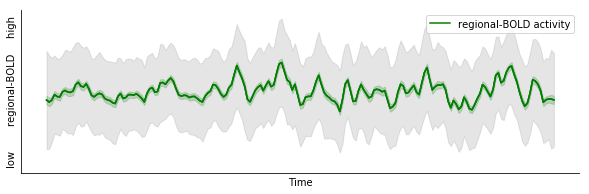

In [49]:
f = plt.figure(figsize=(10,3));
    
for curr_region in [6]:  #, 46, 220, 175, 182]: #can also plot further regions to gauge specificity - aka global signal and functional connectivity
    red_data = ts_data_undet[:, curr_region, :].T
    d = []
    for f in range (red_data.shape[0]):
        d.append(scipy.stats.zscore(red_data[f,:]))
    stacked_acc = np.asarray(d)

    d = np.hstack(stacked_acc)
    h = np.hstack([np.arange(n_tr)] * red_data.shape[0])
    dh = np.vstack((d,h)).T
    df_dh = pd.DataFrame(data =  dh, columns = ['a','b'])

    sns.lineplot(x="b", y="a", ci = 'sd', color = 'gray', data=df_dh);
    sns.lineplot(x="b", y="a", ci = 95, color = 'green', data=df_dh);
    plt.plot(np.mean(stacked_acc, axis = 0), color ='green', label = 'regional-BOLD activity');
plt.ylabel('low        regional-BOLD       high');
plt.xlabel('Time');
plt.ylim(-2, 2);
plt.xticks([]);
plt.yticks([]);
plt.legend();
sns.despine();

### create combination of ISC and raw data 

We can thus try to e.g. create a combined processing and activation measure, i.e. by multiplying the dynamic ISC with the current activation values.

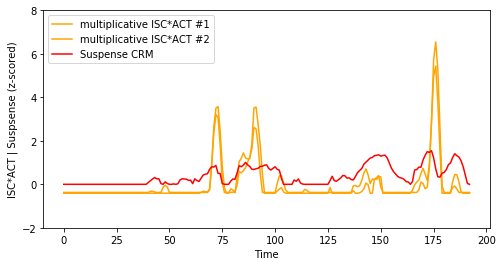

In [51]:
# get the dynamic ISC and activation data for subgroups
isc1 = scipy.stats.zscore(dyn_isc_result[0,:,curr_region])
isc2 = scipy.stats.zscore(dyn_isc_result[1,:,curr_region])
act1 = scipy.stats.zscore(roll_vals1)  
act2 = scipy.stats.zscore(roll_vals2) 

# if either one is below average, set the one of the multiplicands to zero
act1[act1<0] = 0
act2[act2<0] = 0
isc1[isc1<0] = 0
isc2[isc2<0] = 0

# multiply the isc and the activation. Thus, if either is low, product will be low, if both are high, product will be high
mult1 = scipy.stats.zscore((act1 * isc1))
mult2 = scipy.stats.zscore((act2 * isc2))

f = plt.figure(figsize=(8,4))
ax1 = f.add_subplot(111)
ax1.plot(mult1, color = 'orange', label = 'multiplicative ISC*ACT #1');
ax1.plot(mult2, color = 'orange', label = 'multiplicative ISC*ACT #2');

susp1 = scipy.stats.zscore(suspense)  #use only moments where suspense is above average ...
susp1[susp1<0]= 0 
ax1.plot(susp1, color = 'red', label = 'Suspense CRM');

plt.legend(loc = 2);
plt.ylim(-2, 8);
plt.xlabel('Time');
plt.ylabel('ISC*ACT | Suspsense (z-scored)');

this analysis poses the interesting question: might people who turn their dials actually be no longer able to 
increase their scores because they maxed them out earlier? It is well known (e.g. Psychophysics) that rating data are inherently relative and people respond more to changes than they are able to report direct magnitudes/numbers. Here, by asking the brain, there seems a possibility to get a purer measure (although this one will have similar range limitations as well at some point).